In [1]:
import os

import random, os
import numpy as np
import torch
import importlib
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE import objVAE, MultiheadAttention
from objVAE import utils

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

print(torch.cuda.is_available())
torch.set_float32_matmul_precision('medium')
seed_everything(42)

True


In [2]:
def combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        #new_attention_row = attention_to_next_dt
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    expanded_a = np.transpose(expanded_a, (2, 1, 0))
    square_difference = np.square(
        expanded_a - expanded_b
    )  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

def distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

def run_test(testset, model, combine_radius, plot_num=0, num_entities=10, pres_floor=0.25, tra_floor=0.25, tail_length=2):
    lines_v = []
    for i_seq, x in enumerate(testset):

        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        recon, indices, pres, kl_divergence, xy_pred, mu, logvar, attention, xy = model(x)

        x = x.detach().cpu().numpy()
        recon = recon.detach().cpu().numpy()
        pres = pres.detach().cpu().numpy()
        xy = xy.detach().cpu().numpy()

        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(xy.shape[0]):

            xp = xy[i, :, 0]
            yp = xy[i, :, 1]

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(20, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
                & matrix.astype(bool)
            ).astype(np.int32)

            pres_mask = pres[i] <= pres_floor

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0) + pres_mask

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(xy.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                    for ann in annotations:
                        ann.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(bool)],
                    xp[~remove_map_v[i].astype(bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                annotations = []
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    annotations.append(
                        plt.annotate(
                            round(pres[i, j], 3), (yp[j], xp[j]), color="white"
                        )
                    )
                plt.subplot(1, 2, 2)
                plt.imshow(recon[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )
            #new_attention = attention_to_next.detach().cpu().numpy()

            if i_seq == plot_num:
                print(new_attention)

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            binary_attention *= np.where(new_attention >= tra_floor, 1, 0)


            if i_seq == plot_num:
                if len(lines_v) > tail_length:
                    lines = lines_v.pop(0)
                    for line in lines:
                        line.pop(0).remove()

                plt.subplot(1, 2, 1)
                cols = np.where(binary_attention == 1)
                #cols = np.argmax(binary_attention, axis=1)
                lines = []
                for i_col, _ in enumerate(cols[0]):
                    previous = cols[0][i_col]
                    current = cols[1][i_col]
                    if remove_map_v[i - 1][previous] or remove_map_v[i][current]:
                        continue
                    x_line = [xp_v[i - 1][previous], xp_v[i][current]]
                    y_line = [yp_v[i - 1][previous], yp_v[i][current]]

                    line = plt.plot(y_line, x_line, c="b")
                    lines.append(line)
                lines_v.append(lines)

                plt.savefig(f"../results/gif/fig_{i}.png")


def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        recon, indices, pres, kl_divergence, presence_loss, delta_xy_pred, mu, logvar, attention, xy = model(x)
        alpha = pres[0].detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[0, alpha]
        edge_color = plt.cm.get_cmap('spring')(pres[0, alpha].detach().cpu().numpy())

    else:
        recon, indices, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        xy = xy.detach().cpu().numpy()[0, :]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(
        recon[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

torch.Size([23, 5, 1, 520, 696])
tensor(-2.2535) tensor(3.9141)


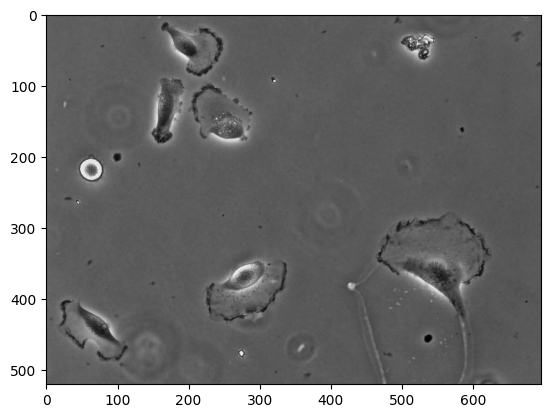

In [3]:
import tifffile
from glob import glob

x_crop = 256
y_crop = 256

paths = r'/home/gideon/data/mp_mpa/PhC-C2DH-U373/*.tif'
paths = glob(paths)

images = [
    tifffile.imread(path) for path in paths
]
 
images = np.array(images)
images = np.array(np.split(images, 23, axis=0))


training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(1, 2, 3), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=2)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[2,0,:,:,:]), cmap='gray')

print(torch.min(training_images), torch.max(training_images))

In [4]:
train, test = torch.utils.data.random_split(training_images, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(training_images, batch_size=2, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test, batch_size=2, shuffle=False, num_workers=0)

In [5]:
import IPython.display as ipd

# Callbacks
max_steps = 20000
beta_annealing_end = 1800
lr_annealing_end = max_steps
kl_annealing_end = 2400 # 2400
presence_annealing_end = 1000

def beta_annealing(step):
    logs = np.logspace(-4, -2.5, beta_annealing_end) # 8.3 - 7
    lins = np.linspace(1, 0, beta_annealing_end)
    if step < beta_annealing_end:
        return lins[step]#logs[int(step)]
    else:
        return 0#logs[-1]
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < 500:
        return 0
    if step < kl_annealing_end:
        return 0#logs[step]
    else:
        return 0#1

def presence_annealing(step):
    lins = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 10:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [8]:
importlib.reload(objVAE)
importlib.reload(MultiheadAttention)

load_model = ""

#load_model = "../state_dicts/model-5-20000-presW-glim32-an.pth"
#load_model = "../state_dicts/model-u373.pth"

# General model settings
num_entities = 10
latent_dim = 8
beta = 1e-4
object_radius = 64
combine_method = "sum"
topk_select_method = 'max'


# Encoder settings
encoder_pooling_layers=4
encoder_layers=1

# Decoder settings
single_decoder = True
decoder="linear"
decoder_feature_size=56 #56
decoder_num_layers=4

# Attention settings
use_attention = False
softmax_tmp = 1
attention_mechanism='cosine-similarity'
number_of_heads = 1
max_t = 1
pos_attention_weight = 100

attention = MultiheadAttention.MultiheadAttention(
    max_t=max_t, attention_mechanism=attention_mechanism, softmax_factor=softmax_tmp, number_of_heads=number_of_heads, num_filters=latent_dim-2, pos_attention_weight=pos_attention_weight
)

model = objVAE.MEVAE(
    num_entities,
    attention_model=attention,
    beta=beta,
    latent_dim=latent_dim,
    attention=use_attention,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_pooling_layers=encoder_pooling_layers,
    encoder_conv_layers=encoder_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))


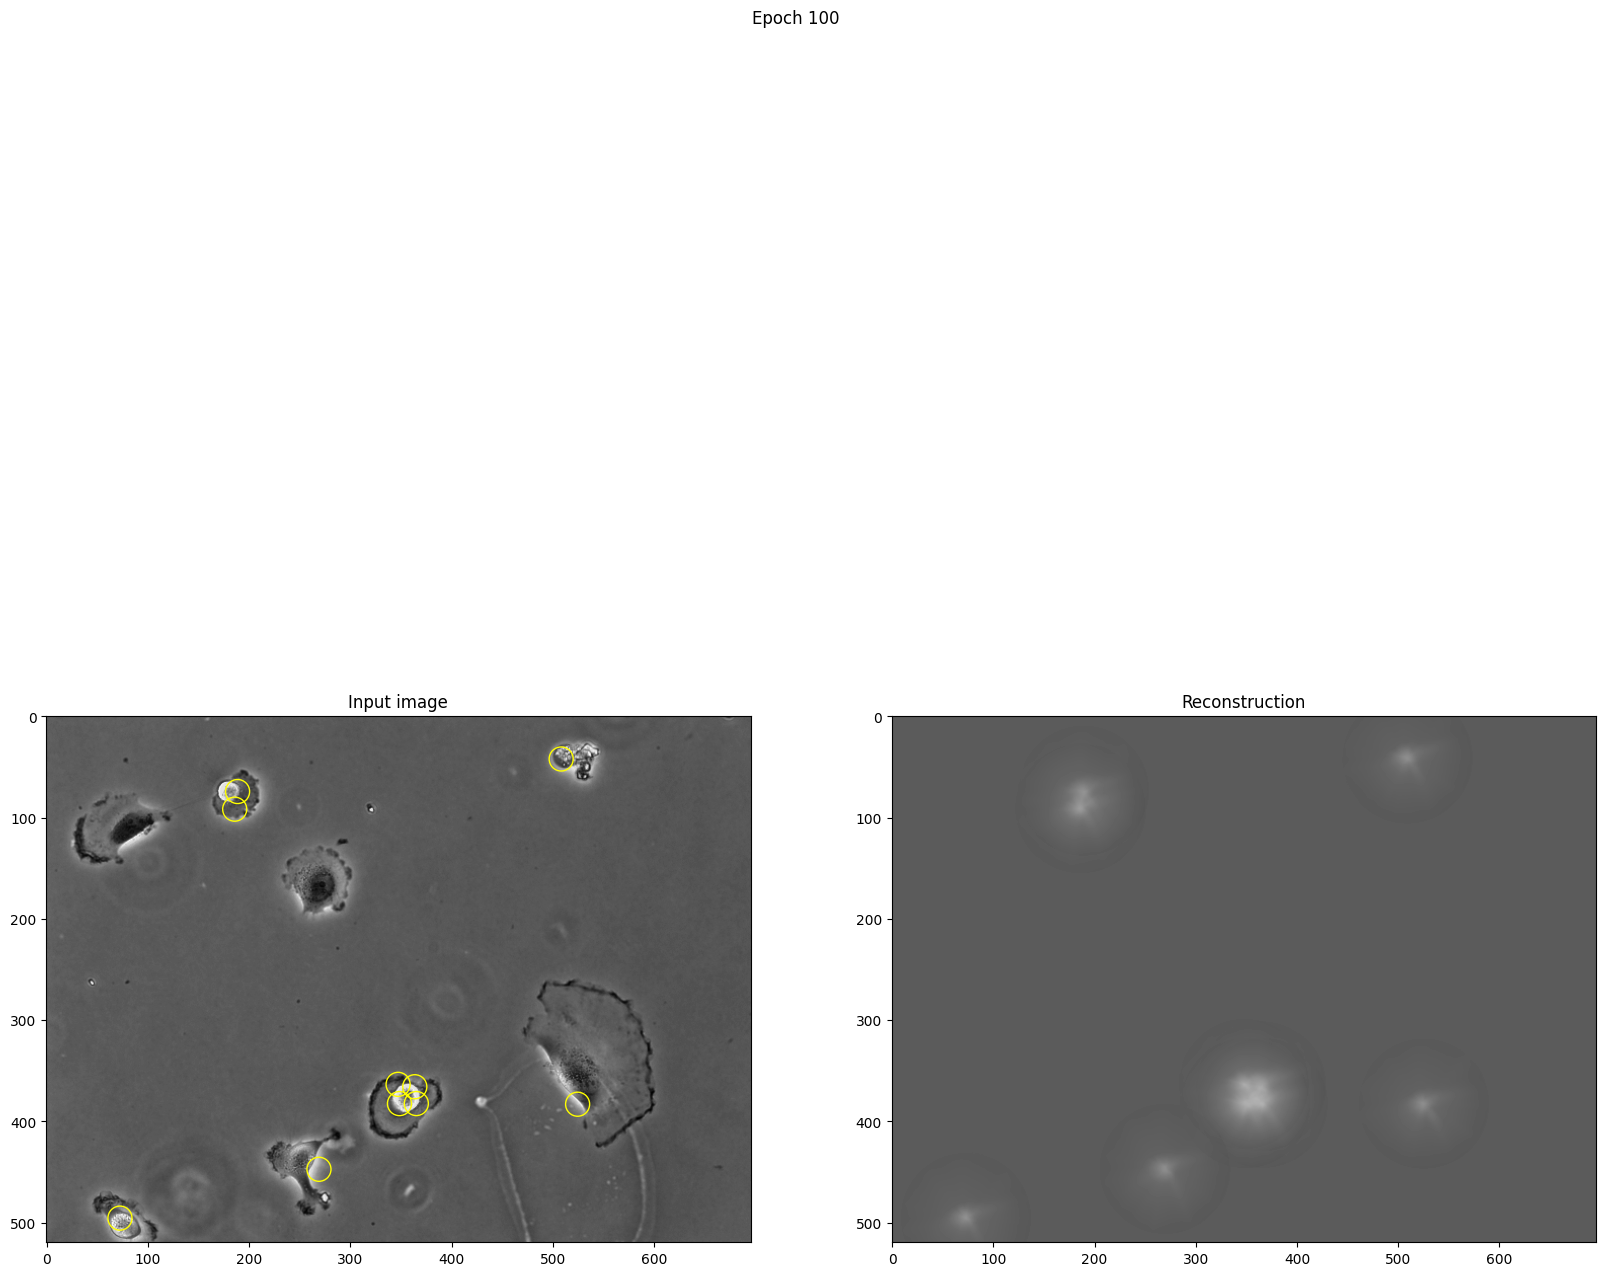

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [9]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

In [ ]:
seq = test[0]

tra_list = model.extract_obj_and_tra(seq, 4, presence_floor=0.25, tra_floor=0.8)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

ValueError: too many values to unpack (expected 9)

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

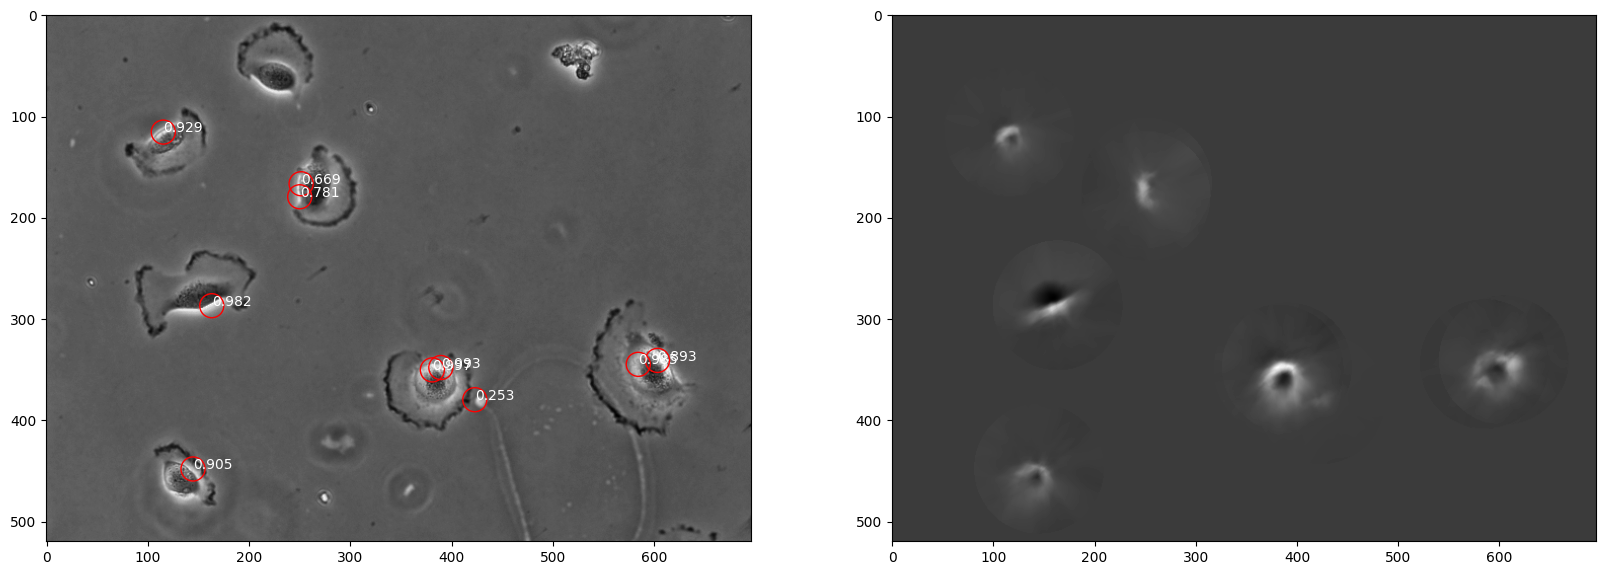

In [17]:
import importlib
importlib.reload(utils)

utils.run_test(
    training_images,
    model,
    combine_radius=8,
    plot_num=0,
    num_entities=10,
    pres_floor=0.25,
    tra_floor=0.99,
    tail_length=3,
    )

In [24]:
torch.save(model.state_dict(), "../state_dicts/model-u373.pth")

## PCA

In [ ]:
latents, new_latents, pres, coords = model.model.extract_latents(training_images.to(model.device))

presence = (torch.squeeze(pres) > 0.25)

latents = latents.view(-1, 3)
new_latents = new_latents.view(-1, 3)
presence = presence.view(-1)

print(latents.shape)
print(new_latents.shape)
print(presence.shape)

latents = latents.detach().cpu().numpy()
new_latents = new_latents.detach().cpu().numpy()
presence = presence.detach().cpu().numpy()

latents = latents[presence, :]
new_latents = new_latents[presence, :]


color = np.ones((latents.shape[0]))*1

OutOfMemoryError: CUDA out of memory. Tried to allocate 382.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 258.00 MiB is free. Including non-PyTorch memory, this process has 5.51 GiB memory in use. Of the allocated memory 5.35 GiB is allocated by PyTorch, and 18.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Cumulative explained variance:  [0.3532733  0.68687427 1.        ]


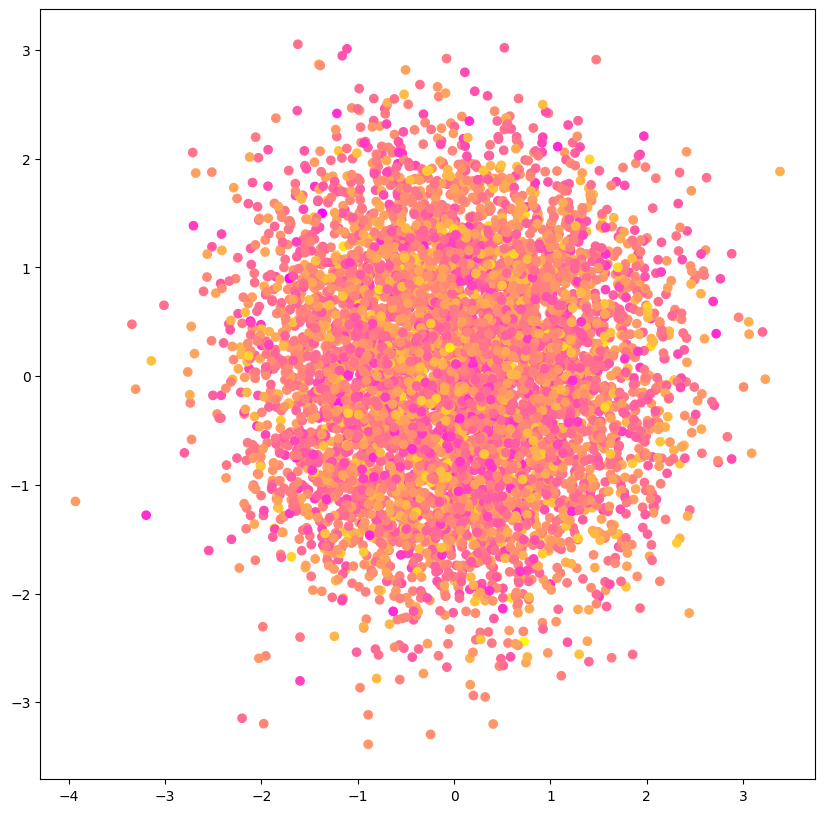

In [ ]:
plt.figure(figsize=(10, 10))
pca_data, _ = utils.pca(latents)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=pca_data[:, 2], cmap='spring')

## PCA extended

In [27]:
latents, new_latents, pres, coords = model.model.extract_latents(training_images[:2].to(model.device))
presence = (torch.squeeze(pres) > 0.25).to(torch.int32)

new_latents = new_latents[:, :, :]
latents = latents[:,:,:]
#new_latents = torch.unsqueeze(new_latents, axis=1)
print(new_latents.shape)

coords = coords.view(-1,2).detach().cpu().numpy()
new_latents_detached = new_latents.view(-1, new_latents.shape[-1]).detach().cpu().numpy()
latents_deetached = latents.view(-1, latents.shape[-1]).detach().cpu().numpy()
presence = presence.view(-1).detach().cpu().numpy()

torch.Size([10, 10, 6])


In [28]:
def reconstruct(index):
    x_range = torch.arange(-training_images.shape[3]/2, training_images.shape[3]/2, device=latents.device, dtype=torch.float32)
    y_range = torch.arange(-training_images.shape[4]/2, training_images.shape[4]/2, device=latents.device, dtype=torch.float32)
    x_grid, y_grid = torch.meshgrid(torch.squeeze(x_range), torch.squeeze(y_range))

    grid_channel = torch.stack([x_grid, y_grid], dim=-1).view(1, 1, -1, 2)
    grid_channel = grid_channel.repeat(latents.shape[0]*1, 1, 1, 1)

    images = model.model.decode_from_latents(torch.unsqueeze(latents[:, index[0]%latents.shape[1], :], axis=1), (training_images.shape[3], training_images.shape[4]), grid_channel)
    images = images.detach().cpu().numpy()

    return images[index[0]//latents.shape[1]]
    
    

def update_point(trace, points, selector):
    if not points.point_inds:
        return
    fig.data = [fig.data[0], fig.data[1]]
    
    recon_image = np.squeeze(reconstruct(points.point_inds))
    fig.add_trace(px.imshow(recon_image, color_continuous_scale='gray').data[0], row=1, col=2)

    ind = points.point_inds[0]//new_latents.shape[1]
    input_image = np.squeeze(training_images[ind//training_images.shape[1], ind%training_images.shape[1], 0, :, :])
    fig.add_trace(px.imshow(input_image, color_continuous_scale='gray').data[0], row=2, col=2)
    fig.add_trace(go.Scatter(x=[coords[points.point_inds[0], 1]], y=[coords[points.point_inds[0], 0]], mode="markers", marker_size=30, marker_symbol='circle-open', marker_line_width=4), row=2, col=2)





In [29]:
import plotly.graph_objects as go
import plotly.express as px
from plotly import subplots

pca_data_new, _ = utils.pca(new_latents_detached[:,:])
pca_data, _ = utils.pca(latents_deetached[:,:])

x = pca_data_new[:,0]
y = pca_data_new[:,1]

color0 = np.zeros((new_latents_detached.shape[0]//4))
color1 = np.ones((new_latents_detached.shape[0]//4))
color2 = np.ones((new_latents_detached.shape[0]//4))*2
color3 = np.ones((new_latents_detached.shape[0]//4))*3


color = np.concatenate((color0, color1, color2, color3))

fig = go.FigureWidget(subplots.make_subplots(rows=2, cols=2))

#fig.add_scatter(x=x, y=y, mode='markers')
fig.add_trace(go.Scatter(x=pca_data[:,0], y=pca_data[:,1], mode='markers', marker_opacity=presence, marker_size=10, marker_line_width=1), row=1, col=1)
fig.add_trace(go.Scatter(x=pca_data_new[:,0], y=pca_data_new[:,1], mode='markers', marker_opacity=presence, marker_size=10, marker_line_width=1), row=2, col=1)
scatter = fig.data[0]
scatter.on_click(update_point)
fig.data[1].on_click(update_point)

fig.layout.title = 'PCA'
fig.layout.xaxis.title = 'PC1'
fig.layout.yaxis.title = 'PC2'
fig.layout.hovermode = 'closest'
fig.layout.width = 1200
fig.layout.height = 1200
fig.update_coloraxes(colorscale='gray')


fig

Cumulative explained variance:  [0.62593126 0.8370629  0.94983764 0.97577041 0.98919986 1.        ]
Cumulative explained variance:  [0.4871689  0.78806681 0.92389358 0.9662562  0.98452088 1.        ]


FigureWidget({
    'data': [{'marker': {'line': {'width': 1},
                         'opacity': array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                           1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                           1, 1, 1, 1], dtype=int32),
                         'size': 10},
              'mode': 'markers',
              'type': 'scatter',
              'uid': 'a52f3beb-e0aa-4412-a26b-c6632cd8be5f',
              'x': array([-11.66573164,   5.284179  ,   1.07519854,  -8.43461982,   2.25930791,
                            3.36053054,   1.6314793 ,   3.53999717,  -7.0367149 ,  -4.23673741,
                           -3.72895985,   2.3369435